<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [1]:
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import glob
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import os
os.path.isfile('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918')
import sys
import time
import cv2
try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        print((1))
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass

import caiman as cm
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.utilities import detrend_df_f
from caiman.components_evaluation import estimate_components_quality_auto
import bokeh.plotting as bpl
bpl.output_notebook()

1


Loading BokehJS ...

### Setup some parameters

In [2]:
# dataset dependent parameters
fname = ['/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G.tiff',
         '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T4_G.tiff'
         ]  

# filename to be processed
fr = 4                             # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
niter_rig = 1               # number of iterations for rigid motion correction
max_shifts = (6, 6)         # maximum allow rigid shift
splits_rig = 2          # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
splits_els = 2         # for parallelization split the movies in  num_splits chuncks across time
upsample_factor_grid = 4    # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3     # maximum deviation allowed for patch with respect to rigid shifts

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thresh = 0.8          # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [4, 4]               # expected half size of neurons
init_method = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
is_dendrites = False        # flag for analyzing dendritic data
alpha_snmf = None           # sparsity penalty for dendritic data analysis through sparse NMF

# parameters for component evaluation
min_SNR = 2.5               # signal to noise ratio for accepting a component
rval_thr = 0.8              # space correlation threshold for accepting a component
cnn_thr = 0.8               # threshold for CNN based classifier

Download the dataset if not already present

In [3]:
if fname[0] in ['Sue_2x_3000_40_-46.tif','demoMovie.tif']:
    fname = [download_demo(fname[0])]

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [4]:
m_orig = cm.load_movie_chain(fname[:2])
downsample_ratio = 0.2
offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
m_orig.resize(1, 1, downsample_ratio).play(
gain=10, offset=offset_mov, fr=4, magnification=2)

100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


reshaping along z


##### Setup a cluster

In [5]:
#%% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
0
0
0
0


/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  retur

10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50
0
0
0
0
0
0
10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50
0
10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50


## Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [6]:
# first we create a motion correction object with the parameters specified
min_mov = min(cm.load(fname[0], subindices=slice(200)).min(),0) 
        # this will be subtracted from the movie to make it non-negative 

mc = MotionCorrect(fname[:2], min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig,
                   splits_rig=splits_rig, 
                   strides= strides, overlaps= overlaps, splits_els=splits_els,
                   upsample_factor_grid=upsample_factor_grid,
                   max_deviation_rigid=max_deviation_rigid, 
                   shifts_opencv = True, nonneg_movie = True)
# note that the file is not loaded in memory

Now perform motion correction. From the movie above we see that the dateset exhibits non-uniform motion. We will perform piecewise rigid motion correction using the NoRMCorre algorithm.

In [7]:
%%capture
#%% Run piecewise-rigid motion correction using NoRMCorre
mc.motion_correct_pwrigid(save_movie=True)
m_els = cm.load(mc.fname_tot_els)
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)  
    # maximum shift to be used for trimming against NaNs

Inspect the results by comparing the original movie. A more detailed presentation of the motion correction method can be found in the [demo motion correction](./demo_motion_correction.ipynb) notebook.

In [8]:
#%% compare with original movie
cm.concatenate([m_orig.resize(1, 1, downsample_ratio)+offset_mov,
                m_els.resize(1, 1, downsample_ratio)], 
               axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit

reshaping along z
reshaping along z


## Memory mapping 

The cell below memory maps the file in order `C` and then loads the new memory mapped file.

In [9]:
#%% MEMORY MAPPING
# memory map the file in order 'C'
fnames = mc.fname_tot_els   # name of the pw-rigidly corrected file.
border_to_0 = bord_px_els     # number of pixels to exclude
fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C',
                           border_to_0 = bord_px_els) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

RECOMPUTING EACH FILE MEMORY MAP
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G._els__d1_301_d2_300_d3_1_order_F_frames_108_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T4_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap', 108)
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap', 109)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap__d1_301_d2_300_d3_1_order_C_frames_217_.mmap
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_

(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(26187, 27090)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(27090, 27993)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(27993, 28896)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/dataset

(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(63210, 64113)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(64113, 65016)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(65016, 65919)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/dataset

Now restart the cluster to clean up the memory

In [10]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
(217, 31, 30)
using 1 processes
(217, 31, 31)
using 1 processes
using 225 pixels per process
using 1 processes
using 1 processes
using 225 pixels per process
(217, 31, 31)
using 5000 block_size
using 225 pixels per process
preprocessing ...
using 225 pixels per process
using 1 processes
using 5000 block_size
using 5000 block_size
checking if missing data
using 5000 block_size
preprocessing ...
using 1 processes
using 225 pixels per process
using 5000 block_size
using 225 pixels per process
preprocessing ...
using 5000 block_size
checking if missing data
checking if missing data
preprocessing ...
preprocessing ...
preprocessing ...
checking if missing data
checking if missing data
checking if missing data
initializing ...
initializing ...
Noise Normalization
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
initializ

using 1 processes
(217, 31, 31)
(Hals) Refining Components...
using 225 pixels per process
Spatial Downsampling 2-photon
using 1 processes
using 225 pixels per process
using 1 processes
using 5000 block_size
using 5000 block_size
preprocessing ...
reshaping along x and y
checking if missing data
preprocessing ...
(108, 15)
reshaping along z
using 225 pixels per process
checking if missing data
***** OPENCV!!!!
using 5000 block_size
Roi Extraction...
preprocessing ...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
checking if missing data
initializing ...
False
Noise Normalization
(217, 31, 31)
(217, 31, 31)
Spatial Downsampling 2-photon
reshaping along x and y
using 1 processes
using 1 processes
(108, 15)
using 225 pixels per process
using 225 pixels per process
using 5000 block_size
initializing ...
reshaping along z
using 5000 block_size
***** OPENCV!!!!
Noise Normalization
preprocessing ...
initializ

using 1 processes
using 1 processes
USING ROLLING SUM FOR INITIALIZATION....
using 225 pixels per process
using 225 pixels per process
using 5000 block_size
using 5000 block_size
preprocessing ...
(Hals) Refining Components...
preprocessing ...
checking if missing data
checking if missing data
False
False
(217, 31, 31)
(217, 31, 31)
False
using 1 processes
using 1 processes
using 225 pixels per process
using 225 pixels per process
(Hals) Refining Components...
using 5000 block_size
initializing ...
preprocessing ...
using 5000 block_size
preprocessing ...
Noise Normalization
Spatial Downsampling 2-photon
checking if missing data
reshaping along x and y
checking if missing data
(217, 31, 31)
(108, 15)
using 1 processes
initializing ...
reshaping along z
using 225 pixels per process
Noise Normalization
using 5000 block_size
***** OPENCV!!!!
Spatial Downsampling 2-photon
preprocessing ...
Roi Extraction...
False
checking if missing data
reshaping along x and y
(108, 15)
Greedy initializat

reshaping along x and y
reshaping along x and y
(108, 15)
using 225 pixels per process
False
reshaping along z
using 5000 block_size
preprocessing ...
(108, 15)
(217, 31, 31)
***** OPENCV!!!!
reshaping along z
Roi Extraction...
***** OPENCV!!!!
using 1 processes
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
using 225 pixels per process
checking if missing data
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
using 5000 block_size
USING ROLLING SUM FOR INITIALIZATION....
preprocessing ...
initializing ...
checking if missing data
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(Hals) Refining Components...
(108, 15)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
initializing ...
Noise 

(108, 15)
reshaping along x and y
Spatial Downsampling 2-photon
reshaping along x and y
reshaping along z
(108, 15)
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(217, 31, 31)
USING ROLLING SUM FOR INITIALIZATION....
(108, 15)
using 1 processes
reshaping along z
initializing ...
using 225 pixels per process
***** OPENCV!!!!
Roi Extraction...
using 5000 block_size
reshaping along z
***** OPENCV!!!!
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
preprocessing ...
USING ROLLING SUM FOR INITIALIZATION....
checking if missing data
Noise Normalization
Roi Extraction...
(Hals) Refining Components...
Spatial Downsampling 2-photon
reshaping along x and y
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(108, 15)
USING ROLLING SUM FOR INITIALIZATION....
reshaping along z
False
***** OPENCV!!!!
(217, 31, 31)
Roi Extraction...
using 1 pr

initializing ...
Noise Normalization
Noise Normalization
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
reshaping along x and y
(Hals) Refining Components...
reshaping along x and y
reshaping along x and y
(108, 15)
(108, 15)
(108, 15)
reshaping along z
False
reshaping along z
reshaping along z
***** OPENCV!!!!
Roi Extraction...
***** OPENCV!!!!
***** OPENCV!!!!
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Roi Extraction...
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(217, 31, 31)
USING ROLLING SUM FOR INITIALIZATION....
False
using 1 processes
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
using 225 pixels per process
False
USING ROLLING SUM FOR INITIALIZATION....
(217, 31, 31)
using 5000 block_size
preprocessing ...
checking if miss

Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(217, 31, 31)
using 1 processes
False
using 225 pixels per process
(217, 31, 31)
False
using 1 processes
using 225 pixels per process
using 5000 block_size
initializing ...
preprocessing ...
Noise Normalization
Spatial Downsampling 2-photon
(217, 31, 31)
using 5000 block_size
preprocessing ...
checking if missing data
reshaping along x and y
checking if missing data
using 1 processes
initializing ...
(108, 15)
using 225 pixels per process
Noise Normalization
Spatial Downsampling 2-photon
using 5000 block_size
reshaping along z
reshaping along x and y
***** OPENCV!!!!
preprocessing ...
checking if missing data
Roi Extraction...
(108, 15)
reshaping along z
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(Hals) Refining Components...
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal compo

using 225 pixels per process
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
using 5000 block_size
initializing ...
initializing ...
False
Noise Normalization
Noise Normalization
(217, 31, 31)
preprocessing ...
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
checking if missing data
reshaping along x and y
reshaping along x and y
initializing ...
(Hals) Refining Components...
using 1 processes
(108, 15)
Noise Normalization
reshaping along z
using 225 pixels per process
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
using 5000 block_size
reshaping along z
(108, 15)
***** OPENCV!!!!
***** OPENCV!!!!
False
Roi Extraction...
reshaping along z
preprocessing ...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(217, 31, 31)
checking if

using 1 processes
using 225 pixels per process
(108, 15)
initializing ...
using 5000 block_size
Noise Normalization
using 225 pixels per process
reshaping along z
using 5000 block_size
Spatial Downsampling 2-photon
preprocessing ...
checking if missing data
reshaping along x and y
preprocessing ...
(108, 15)
checking if missing data
***** OPENCV!!!!
reshaping along z
Roi Extraction...
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
USING ROLLING SUM FOR INITIALIZATION....
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(Hals) Refining Components...
(108, 15)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
False
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(217, 31, 31)
initializing ...
Nois

/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 i

tB:-2.0,tA:5.0
Computing event exceptionality delta
tB:-2.0,tA:5.0
Computing event exceptionality delta
tB:-2.0,tA:5.0
tB:-2.0,tA:5.0
Removing Baseline
Computing event exceptionality delta
Computing event exceptionality delta
binning data ...
interpolating data ...
Removing Baseline
tB:-2.0,tA:5.0
Removing Baseline
(6, 50)
tB:-2.0,tA:5.0
Removing Baseline
binning data ...
Computing event exceptionality delta
Computing event exceptionality
interpolating data ...
(6, 50)
binning data ...
binning data ...
interpolating data ...
(6, 50)
Computing event exceptionality delta
Computing event exceptionality
Computing event exceptionality
Evaluating spatial footprint
interpolating data ...
(6, 50)
Computing event exceptionality
Evaluating spatial footprint
Removing Baseline
Removing Baseline
binning data ...
binning data ...
interpolating data ...
Evaluating spatial footprint
(6, 50)
Evaluating spatial footprint
components evaluated:0
interpolating data ...
(6, 50)
components evaluated:0
compon

## Run CNMF on patches in parallel

<p> <img src="../../docs/img/cnmf1.png" /> </p>

- The FOV is split is different overlapping patches that are subsequently processed in parallel by the CNMF algorithm.
- The results from all the patches are merged with special attention to idendtified components on the border.
- The results are then refined by additional CNMF iterations.

In [11]:
%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
t1 = time.time()

cnm = cnmf.CNMF(n_processes=1, k=K, gSig=gSig, merge_thresh= merge_thresh, 
                p = 0,  dview=dview, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, 
                only_init_patch = False, gnb = gnb, border_pix = bord_px_els) 
cnm = cnm.fit(images)

plot contours of identified components against correlation image

/home/murthyhacker/CaImAn/caiman/summary_images.py:206: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


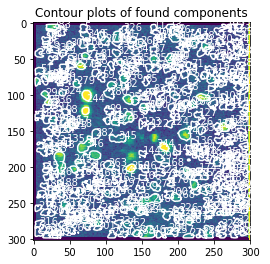

In [12]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
plt.figure(); crd = plot_contours(cnm.A, Cn, thr=0.9)
plt.title('Contour plots of found components')

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [13]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    estimate_components_quality_auto(images, cnm.A, cnm.C, cnm.b, cnm.f, 
                                     cnm.YrA, fr, decay_time, gSig, dims, 
                                     dview = dview, min_SNR=min_SNR, 
                                     r_values_min = rval_thr, use_cnn = False, 
                                     thresh_cnn_lowest = cnn_thr)

EVALUATING IN PARALLEL... NOT RETURNING ERFCs


Plot contours of selected and rejected components

/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


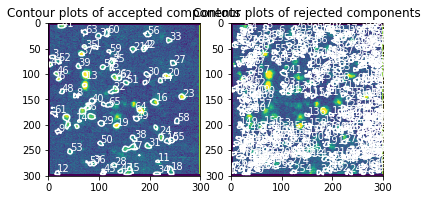

In [14]:
#%% PLOT COMPONENTS

plt.figure();
plt.subplot(121); crd_good = cm.utils.visualization.plot_contours(cnm.A[:,idx_components], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of accepted components')
plt.subplot(122); crd_bad = cm.utils.visualization.plot_contours(cnm.A[:,idx_components_bad], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of rejected components')

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [15]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons =Cn,
                denoised_color = 'red');

#np.set_printoptions(threshold=np.nan)




           1           2           3           4           5           6    \
1    15.783332   30.987951    0.000000    0.000000   34.532440    0.000000   
2     7.526772    1.943725    0.000000   14.879901    0.000000    7.131595   
3    30.142349   13.691769   51.284251   22.794660   70.509361   20.028005   
4     0.000000   47.754045    0.000000    0.000000    0.000000    0.000000   
5     4.544936   24.917697   51.939731   13.841814    0.000000   37.174655   
6     0.000000   39.561511    7.806753   50.673402   54.422344    9.608707   
7    21.651750   75.723924   48.097047   21.287473   23.020960    8.555371   
8     0.000000    1.328933    0.000000    3.693713    0.000000    0.000000   
9     7.750937    1.336738    0.000000   18.680532    0.000000    0.000000   
10    6.265762    0.000000    0.000000    0.000000    0.000000   12.399050   
11    0.000000   49.419617    7.795034   19.582580   76.131695   53.636382   
12   18.815110    4.620057    9.305803   12.153287    1.586067  

In [16]:
# rejected components
if len(idx_components_bad) > 0:
    nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                    cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons =Cn,
                    denoised_color = 'red');
else:
    print("No components were rejected.")

           1          2          3          4          5          6    \
1    27.530827  27.266149  21.468896   0.023973  26.164291  11.278276   
2     0.000000  31.416224  10.623926  38.501730  18.374299  27.053622   
3    27.068873   0.000000   0.000000   0.000000   9.719215   0.000000   
4    24.401546   0.912743   0.000000  19.745135  11.033486   8.969445   
5    22.523000  58.624131  41.239592  48.868497  29.847627  26.939126   
6    20.044636   8.152729  35.928206  34.760518  22.883854  22.614227   
7    26.856937  39.884411   9.887047  53.035904  80.737238  82.697921   
8     9.799824  13.101010  68.103891  26.323670   0.000000  11.945520   
9     7.789661   8.898164  25.060243  41.014490   0.000000  29.268809   
10    0.000000   0.000000   0.000000   0.000000  11.564102  27.545071   
11   44.519458  10.009601   3.335088   1.506707   0.000000  28.731040   
12   93.060541   8.403438  21.315112   0.000000  19.892816  34.512664   
13   31.774162  52.095790  19.459578  20.022726  25

## Re-run (seeded) CNMF  on the full Field of View  

In [17]:
%%capture
#%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
A_in, C_in, b_in, f_in = cnm.A[:,idx_components], cnm.C[idx_components], cnm.b, cnm.f
cnm2 = cnmf.CNMF(n_processes=1, k=A_in.shape[-1], gSig=gSig, p=p, dview=dview,
                merge_thresh=merge_thresh,  Ain=A_in, Cin=C_in, b_in = b_in,
                f_in=f_in, rf = None, stride = None, gnb = gnb, 
                method_deconvolution='oasis', check_nan = True)

cnm2 = cnm2.fit(images)

### Extract DF/F values

In [18]:
#%% Extract DF/F values

F_dff = detrend_df_f(cnm2.A, cnm2.b, cnm2.C, cnm2.f, YrA = cnm2.YrA, 
                      quantileMin=8, frames_window=250)



         1         2         3         4         5         6         7    \
1  -0.161150 -0.026977 -0.139037 -0.230996 -0.046483 -0.182372 -0.018407   
2  -0.036660 -0.123228 -0.212900 -0.012400 -0.059236 -0.002265  0.172234   
3   0.028728 -0.097139  0.216693 -0.096837  0.388866 -0.086151  0.037130   
4  -0.131894  0.404906 -0.188475 -0.132321  0.000261 -0.237688  0.219901   
5  -0.045055  0.110308  0.095727  0.001334 -0.078455  0.070483  0.124559   
6  -0.003421  0.299852  0.091430  0.393868  0.436398  0.106732 -0.069943   
7  -0.046902  0.267943  0.078696 -0.023727 -0.004464 -0.088172  0.223378   
8  -0.177514 -0.101644 -0.142322 -0.156079 -0.195788 -0.224578 -0.192309   
9   0.001692  0.026015 -0.175659  0.388710 -0.037409 -0.143449  0.070366   
10 -0.034637 -0.160433 -0.097486 -0.149955 -0.100813 -0.053700 -0.085230   
11 -0.255778  0.053862 -0.099401 -0.061163  0.059100  0.003411 -0.191910   
12  0.409862  0.342387  0.228811  0.415274  0.055407 -0.058290  0.004147   
13 -0.285429

## Display final results

In [28]:
discard_traces_fluo=nb_view_patches(Yr,cnm2.A, cnm2.C, cnm2.b, cnm2.f,
                                    dims[0], dims[1], thr = 0.8, image_neurons=Cn,
                                    denoised_color='red')
print('you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10')

#from bokeh.plotting import figure
#from bokeh.io import show
#plt.figure();

#plt.imshow(np.reshape(cnm2.A[:,5-1].toarray(), dims, order='F'))

#plt.figure()

#plt.plot(F_dff[5-1][1:100])


           1           2           3           4           5           6    \
1    20.688002   20.688002   20.688002   20.688002   20.688002   20.688002   
2    13.101145   13.101145   13.101145   13.101145   13.101145   13.101145   
3     7.641079    7.641079    7.641079    7.641079   12.207946   11.834719   
4    14.684662   14.684662   14.684662   14.684662   14.684662   14.684662   
5     9.051333   52.463305   46.507673   41.154840   36.343787   39.973967   
6    -2.184839   25.823334   22.551351   25.053421   21.851252   18.939445   
7    12.769217   12.769217   12.769217   12.769217   12.769217   12.769217   
8     7.017954    7.017954    7.017954    7.017954    7.017954    7.017954   
9     6.758140    6.758140    6.758140    6.758140    6.758140    6.758140   
10    8.518238    8.518238    8.518238    8.518238    8.518238    8.518238   
11    1.356314    4.618915    4.386926    4.171434    3.971263    3.785326   
12    6.321471    6.321471    6.321471    6.321471    6.321471  

you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10


<h1> closing, saving, and creating denoised version </h1>

In [20]:
save_results = False
if save_results:
    np.savez(os.path.join(os.path.split(fname_new)[0], 
                          os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'),
             Cn=Cn, A=cnm2.A.todense(), C=cnm2.C,
             b=cnm2.b, f=cnm2.f, YrA=cnm2.YrA, sn=sn, d1=d1, d2=d2,
             idx_components=idx_components, idx_components_bad=idx_components_bad)

## stop cluster and clean up LOG files

In [21]:
#%% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

We can inspect the denoised results by reconstructing the movie and playing alongside the original

In [22]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm2.A.dot(cnm2.C) + \
                    cnm2.b.dot(cnm2.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

reshaping along z
reshaping along z


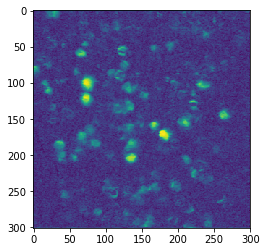

In [38]:
#%% play along side original data
cm.concatenate([m_els.resize(1, 1, downsample_ratio),
                denoised.resize(1, 1, downsample_ratio)], 
                axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit
c_img = m_orig.local_correlations(eight_neighbours = True, swap_dim = False) #correlation image
pl.imshow(c_img)